# 天池精准医疗大赛

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import xgboost as xgb


## 导入数据

In [5]:
train_df = pd.read_csv('data/d_train_20180102.csv', encoding='gbk')
#train_df = pd.read_excel('data/d_train_20180120.xlsx', encoding='gbk')
testA_df = pd.read_csv('data/d_test_A_20180102.csv', encoding='gbk')
testB_df = pd.read_csv('data/d_test_B_20180128.csv', encoding ='gbk')

In [6]:
#训练集和测试集链接
frames = [train_df, testA_df, testB_df]
data_df = pd.concat(frames, join='outer',ignore_index = True)
data_df = data_df.reindex_axis(train_df.columns, axis=1)

**增加7个特征**

In [8]:
data_df['AST/ALT'] = data_df['*天门冬氨酸氨基转换酶']/data_df['*丙氨酸氨基转换酶']
data_df['GFR'] = ((data_df['性别']=='男' )+ 0.742*(data_df['性别'] == '女')) * (186 * data_df['肌酐']/88.41 - 1.154*data_df['年龄']-0.203)
data_df['中性粒细胞绝对值'] = data_df['白细胞计数'] * data_df['中性粒细胞%']/100
data_df['淋巴细胞绝对值'] = data_df['白细胞计数'] * data_df['淋巴细胞%']/100
data_df['单核细胞绝对值'] = data_df['白细胞计数'] * data_df['单核细胞%']/100
data_df['嗜酸细胞绝对值'] = data_df['白细胞计数'] * data_df['嗜酸细胞%']/100
data_df['嗜碱细胞绝对值'] = data_df['白细胞计数'] * data_df['嗜碱细胞%']/100

**删除id, 体检日期两个特征，并且对性别特征one-hot编码**

In [9]:

onehot = pd.get_dummies(data_df['性别'])
data_df = onehot.iloc[:,1:3].join(data_df) #由于id=580这一条数据的性别为：??,所以这里将其性别的one-hot编码为00
#data_df['性别'] = data_df['性别'].map({'男':1, '女': 0})
data_df.drop(['id','性别','体检日期'],axis=1,inplace=True)
data_df.drop([ '乙肝表面抗原', '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体'],axis=1,inplace=True)

In [10]:
#由于删除了血糖为38的一条样本，剩余5641条
train_size = 5641  #原始数据：5642

In [11]:
#重新排列列名，使得最后一列为血糖特征
columns = ['女', '男', '年龄', '*天门冬氨酸氨基转换酶', '*丙氨酸氨基转换酶', '*碱性磷酸酶', '*r-谷氨酰基转换酶',
       '*总蛋白', '白蛋白', '*球蛋白', '白球比例', '甘油三酯', '总胆固醇', '高密度脂蛋白胆固醇', '低密度脂蛋白胆固醇',
       '尿素', '肌酐', '尿酸', '白细胞计数', '红细胞计数', '血红蛋白', '红细胞压积', '红细胞平均体积',
       '红细胞平均血红蛋白量', '红细胞平均血红蛋白浓度', '红细胞体积分布宽度', '血小板计数', '血小板平均体积',
       '血小板体积分布宽度', '血小板比积', '中性粒细胞%', '淋巴细胞%', '单核细胞%', '嗜酸细胞%', '嗜碱细胞%',
     'AST/ALT', 'GFR', '中性粒细胞绝对值', '淋巴细胞绝对值', '单核细胞绝对值', '嗜酸细胞绝对值',
       '嗜碱细胞绝对值','血糖']
data_df = data_df.reindex_axis(columns, axis=1)

In [12]:
feat_generate = pd.DataFrame()
feat_generate['22*25'] = data_df.iloc[:,22] * data_df.iloc[:,25]
feat_generate['17*35'] = data_df.iloc[:,17] * data_df.iloc[:,35]
feat_generate['2+30'] = data_df.iloc[:, 2] + data_df.iloc[:, 30]
feat_generate['13*17'] = data_df.iloc[:,13] * data_df.iloc[:,17]
feat_generate['2*19'] = data_df.iloc[:,2] * data_df.iloc[:,19]

feat_generate['22divide24'] = data_df.iloc[:,22] / data_df.iloc[:,24]
feat_generate['2divide35'] = data_df.iloc[:,2] / data_df.iloc[:,35]
feat_generate['15divide17'] = data_df.iloc[:,15] / data_df.iloc[:,17]
feat_generate['2divide25'] = data_df.iloc[:,2] / data_df.iloc[:,25]
feat_generate['19divide25'] = data_df.iloc[:,19] / data_df.iloc[:,25]


In [13]:
feat_generate[data_df.columns] = data_df 
data_df = feat_generate

In [14]:
feat = ['2*19','甘油三酯','*天门冬氨酸氨基转换酶','*r-谷氨酰基转换酶','22*25', '2divide35','15divide17', '2+30',\
           '总胆固醇', '22divide24', '2divide25', '*碱性磷酸酶', '13*17', '高密度脂蛋白胆固醇', '17*35', 'AST/ALT',\
           '嗜碱细胞绝对值', '尿酸', '单核细胞绝对值', '嗜酸细胞绝对值', '*总蛋白', '血小板体积分布宽度', '血红蛋白',\
           'GFR', '红细胞压积', '白球比例', '血小板平均体积','中性粒细胞绝对值','低密度脂蛋白胆固醇', '红细胞平均血红蛋白浓度',\
          '*丙氨酸氨基转换酶', '中性粒细胞%', '19divide25', '白细胞计数', '*球蛋白', '尿素', '血小板比积', '肌酐', '血小板计数',\
          '淋巴细胞绝对值', '白蛋白', '淋巴细胞%', '单核细胞%', '红细胞平均体积', '红细胞计数', '嗜酸细胞%', '红细胞体积分布宽度', \
          '年龄', '红细胞平均血红蛋白量', '女', '嗜碱细胞%', '男']


In [15]:
data_df1 = data_df[feat[0:32]]
data_df1['血糖'] = data_df['血糖']

C:\Program Files\setup\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
data_df.shape

(7641, 53)

In [17]:
#train_df = data_df.iloc[0:train_size,:]
train_df = data_df1.iloc[0:6641,:]
testA = data_df1.iloc[5641:6641,:]
testB = data_df1.iloc[6641:,:]

In [18]:
print('train:',train_df.shape,'\ntestA：',testA.shape,'\ntestB:',testB.shape)

train: (6641, 33) 
testA： (1000, 33) 
testB: (1000, 33)


In [19]:
#将数据分开
#训练
x_train = train_df.iloc[:,0:-1]
y_train = train_df.iloc[:,-1]
#测试
x_test = testB.iloc[:,0:-1]

## XGBoost模型

In [20]:
from sklearn.metrics import mean_squared_error
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', 1/2*mean_squared_error(y, yhat)

In [21]:
#将数据转化为xgboost对应的输入数据格式
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)
print('x_train: ',x_train.shape,'\nx_test:', x_test.shape)

x_train:  (6641, 32) 
x_test: (1000, 32)


In [22]:
#xgboost 参数
xgb_params = {
    'seed': 0,
    'eta': 0.02,
    'learning_rate':0.1,
    #'min_child_weight':3,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': 0.6,
    'objective': 'reg:linear',
    'max_depth':3,     #避免过拟合，值越大，模型会学到更具体更局部的样本，一般3-5
    'min_child_weight':3,
    'reg_lambda':0.35,
    'reg_alpha':10,
    'gamma':0.2,
}

bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=5, seed=2, 
                    feval=xg_eval_mae, maximize=False)

print ('CV score:', 1/2 * bst_cv1.iloc[-1,:]['test-rmse-mean']**2)
print ('train score:', 1/2 * bst_cv1.iloc[-1,:]['train-rmse-mean']**2)

CV score: 0.852937111359
train score: 0.600637373159


In [23]:
bst_cv1.iloc[-1,:]

test-mae-mean      0.853745
test-mae-std       0.052816
test-rmse-mean     1.306091
test-rmse-std      0.040203
train-mae-mean     0.600697
train-mae-std      0.012064
train-rmse-mean    1.096027
train-rmse-std     0.010948
Name: 99, dtype: float64

**绘制误差曲线随着迭代次数的变化趋势**

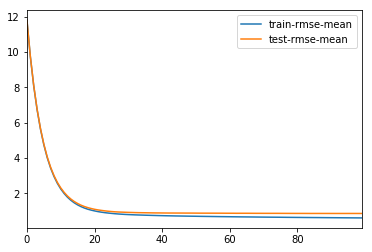

In [24]:
import  matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
(bst_cv1[['train-rmse-mean', 'test-rmse-mean']]**2 * 0.5).plot()

### 对测试集预测

In [25]:
bst = xgb.train(xgb_params, dtrain, num_boost_round=100) 
y_pred = bst.predict(dtest)

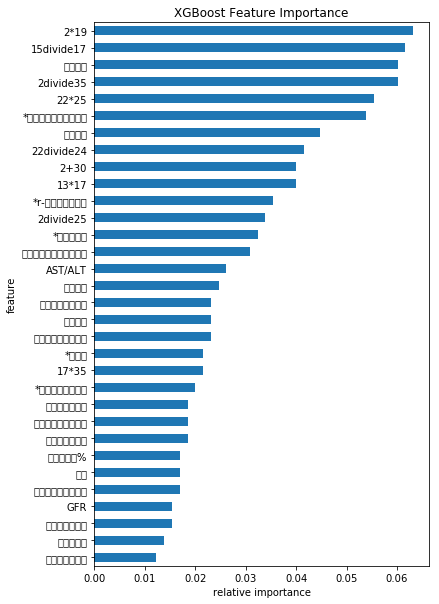

In [26]:
import operator
importance = bst.get_fscore()  
importance = sorted(importance.items(), key=operator.itemgetter(1))  
  
df = pd.DataFrame(importance, columns=['feature', 'fscore'])  
df['fscore'] = df['fscore'] / df['fscore'].sum()  
df.to_csv("feat_combine_importance.csv", index=False)  
  
plt.figure()  
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))  
plt.title('XGBoost Feature Importance')  
plt.xlabel('relative importance')  
plt.show()  

In [27]:
bst = xgb.train(xgb_params, dtrain, num_boost_round=100) 
y_pred = bst.predict(dtest)

In [28]:
s = pd.Series(y_pred) 

In [30]:
s.describe()

count    1000.000000
mean        5.590151
std         0.691109
min         4.555100
25%         5.118604
50%         5.417735
75%         5.854177
max        10.887362
dtype: float64

In [32]:
#将预测值导出到文件
s.to_csv('result/features_select_xgb.csv',index = False)